In [1]:
# -----------------------------------------------
# 1) INSTALL AND IMPORT DEPENDENCIES
# -----------------------------------------------

!pip install --upgrade tensorflow==2.19.0

!pip install -q tensorflow_decision_forests
# For text preprocessing
# !pip install -q spacy
# !python -m spacy download en_core_web_sm

import numpy as np
import pandas as pd
import re, nltk, spacy

# NLTK downloads
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# TensorFlow and TF Decision Forests
import tensorflow as tf
import tensorflow_decision_forests as tfdf

# Check library versions
print("TensorFlow version:", tf.__version__)
print("TF-DF version:", tfdf.__version__)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 86.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 87.2 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.18.0
    Uninstalling tensorflow-2.18.0:
      Successfully uninstalled tensorflow-2.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.19.0 w

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


TensorFlow version: 2.19.0
TF-DF version: 1.12.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# -----------------------------------------------
# 2) LOAD AND PREVIEW YOUR DATA
# -----------------------------------------------

# Example: if the file is in your Colab environment:

df = pd.read_csv("/content/drive/My Drive/Kaggle Club/SARCASM PROJECT '25/cleaned_reddit_comments_NEW.csv")
# df = df[['comment', 'label']]  # Ensure columns match exactly

df["comment"] = df["comment"].str.lower()
df
# print("\nLabel distribution:")
# print(df['label'].value_counts())


,label,comment
0,0,nc and nh
1,0,you do know west team play against west team m...
2,0,they be underdogs early today but since gronk ...
3,0,this meme be not funny none new york nigga one be
4,0,i could use one those tool
...,...,...
1010821,1,i sure that iran and n. korea have technology ...
1010822,1,whatever you do do not vote green
1010823,1,perhaps this be atheist conspiracy to make chr...
1010824,1,slavs get their own country it be call kosovo


In [ ]:
from sklearn.model_selection import train_test_split

strat = df['label']
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 42, stratify= strat)
strat = dummy_df['label']
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 42, stratify= strat)
print('Total dataset is ', df.shape)
print('Train shape is ' , train_df.shape)
print('Valid shape is ' , valid_df.shape)
print('Test shape is ' , test_df.shape)


Total dataset is  (1010826, 2)
Train shape is  (808660, 2)
Valid shape is  (101083, 2)
Test shape is  (101083, 2)


In [ ]:
test_df = pd.concat([test_df, valid_df], ignore_index=True)
test_df

,label,comment
0,0,hey it be just matter time before someone broo...
1,0,but lulu be already 1350 skin skins sale be 97...
2,0,it be tricky than i think
3,1,they keep shoot themselves because we need mor...
4,0,maybe that be why his colon try to kill he rev...
...,...,...
202161,0,catcher have mini panic attack thinking fuck d...
202162,0,i be so sad when he and katy perry break up
202163,1,thank national medium for hype this up so much...
202164,0,it be not like i have not have diarrhea for ho...


# Building N-gram Dictionary

The N-gram dictionary is created using the training dataset only. It is saved into the Drive to avoid having to create it again.

Run time to create: ~1 hr 30 mins

In [ ]:
from collections import defaultdict, Counter
import pickle

def build_ngram_probability_dict(df, threshold=3):
    sarcastic_counts = Counter()
    nonsarcastic_counts = Counter()

    sarcastic_total = 0
    nonsarcastic_total = 0

    for _, row in df.iterrows():
        label = row['label']
        text = str(row['comment']).lower()
        doc = nlp(text)
        tokens = [token.text for token in doc if not token.is_space]

        # Unigrams and bigrams
        unigrams = tokens
        bigrams = [" ".join(pair) for pair in zip(tokens, tokens[1:])]
        all_ngrams = unigrams + bigrams

        if label == 1:  # sarcastic
            sarcastic_total += 1
            sarcastic_counts.update(all_ngrams)
        else:
            nonsarcastic_total += 1
            nonsarcastic_counts.update(all_ngrams)

    # Now build probability dictionary
    ngram_dict = {}
    all_ngrams = set(sarcastic_counts) | set(nonsarcastic_counts)

    for ngram in all_ngrams:
        s_count = sarcastic_counts[ngram]
        ns_count = nonsarcastic_counts[ngram]
        total_count = s_count + ns_count

        if total_count >= threshold:
            ps = s_count / sarcastic_total if sarcastic_total > 0 else 0
            pns = ns_count / nonsarcastic_total if nonsarcastic_total > 0 else 0
            ngram_dict[ngram] = (ps, pns)

    return ngram_dict


# Each key maps an n-gram (string) to a tuple: (Ps, Pns).
ngram_dict = build_ngram_probability_dict(train_df, threshold=3)
save_path = "/content/drive/My Drive/Kaggle Club/SARCASM PROJECT '25/ngram_dict.pickle"
with open(save_path, 'wb') as handle:
    pickle.dump(ngram_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

ngram_dict

{'bangladeshi': (9.892909257289837e-06, 9.892909257289837e-06),
 'thesis': (1.9785818514579673e-05, 1.7312591200257216e-05),
 'spend time': (0.00011376845645883313, 8.656295600128608e-05),
 'hat which': (2.473227314322459e-06, 4.946454628644918e-06),
 'so prod': (7.419681942967378e-06, 2.473227314322459e-06),
 'winless': (4.946454628644918e-06, 2.473227314322459e-06),
 'with elementary': (0.0, 7.419681942967378e-06),
 'for send': (9.892909257289837e-06, 7.419681942967378e-06),
 'economy i': (2.473227314322459e-06, 9.892909257289837e-06),
 'thank fam': (0.0, 1.4839363885934756e-05),
 'story short': (9.892909257289837e-06, 1.2366136571612297e-05),
 'good judge': (9.892909257289837e-06, 0.0),
 'team might': (1.2366136571612297e-05, 9.892909257289837e-06),
 'find few': (7.419681942967378e-06, 1.4839363885934756e-05),
 'tank mount': (7.419681942967378e-06, 0.0),
 'our offense': (3.957163702915935e-05, 3.215195508619197e-05),
 'yaw': (7.419681942967378e-06, 9.892909257289837e-06),
 'their po

In [20]:
import pickle
save_path = "/content/drive/My Drive/Kaggle Club/SARCASM PROJECT '25/ngram_dict.pickle"
with open(save_path, 'rb') as handle:
    ngram_dict = pickle.load(handle)


In [21]:
ngram_dict["11101001"]

(0.0, 2.967872777186951e-05)

In [23]:
print(f"Number of keys: {len(ngram_dict)}")

Number of keys: 305597


In [24]:
ngram_dict_fixed = ngram_dict.copy()
TRAIN_SHAPE = 404330
THRESHOLD = 3

for key in ngram_dict:
    ps_i, pns_i = ngram_dict[key]

    hold1 = ps_i * TRAIN_SHAPE
    hold2 = pns_i * TRAIN_SHAPE
    if hold1>=THRESHOLD or hold2 >= THRESHOLD:
        ps = hold1/(hold1+hold2)
        pns = hold2/(hold1+hold2)
        ngram_dict_fixed[key] = (ps, pns)
    else:
        del ngram_dict_fixed[key]

print(f"Number of keys: {len(ngram_dict_fixed)}")


Number of keys: 235839


In [25]:
ngram_dict_fixed

{'bangladeshi': (0.5, 0.5),
 'thesis': (0.5333333333333333, 0.4666666666666667),
 'spend time': (0.5679012345679012, 0.43209876543209874),
 'so prod': (0.75, 0.24999999999999997),
 'with elementary': (0.0, 1.0),
 'for send': (0.5714285714285714, 0.42857142857142855),
 'economy i': (0.2, 0.8),
 'thank fam': (0.0, 1.0),
 'story short': (0.4444444444444444, 0.5555555555555556),
 'good judge': (1.0, 0.0),
 'team might': (0.5555555555555556, 0.4444444444444444),
 'find few': (0.3333333333333333, 0.6666666666666666),
 'tank mount': (1.0, 0.0),
 'our offense': (0.5517241379310345, 0.4482758620689655),
 'yaw': (0.42857142857142855, 0.5714285714285714),
 'their point': (0.5, 0.5),
 'healthcare free': (0.75, 0.24999999999999997),
 'till': (0.4380776340110906, 0.5619223659889094),
 'hit q.': (0.24999999999999997, 0.75),
 'not spend': (0.5693430656934306, 0.4306569343065693),
 'mechanism that': (0.5, 0.5),
 'to character': (0.46153846153846156, 0.5384615384615384),
 '1 er': (0.8235294117647058, 0.

In [14]:
save_path = "/content/drive/My Drive/Kaggle Club/SARCASM PROJECT '25/ngram_dict_apr6.pickle"
with open(save_path, 'wb') as handle:
    pickle.dump(ngram_dict_fixed, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [30]:
ngram_dict = ngram_dict_fixed
print(len(ngram_dict))
top_sarcastic = sorted(ngram_dict.items(), key=lambda x: x[1][0], reverse=True)[:10]
top_nonsarcastic = sorted(ngram_dict.items(), key=lambda x: x[1][1], reverse=True)[:10]

# Print the top 10 largest probabilities for both categories
print("Top 10 Sarcastic N-grams:")
for ngram, (ps, _) in top_sarcastic:
    print(f"{ngram}: {ps}")

print("\nTop 10 Non-sarcastic N-grams:")
for ngram, (_, pns) in top_nonsarcastic:
    print(f"{ngram}: {pns}")

235839
Top 10 Sarcastic N-grams:
good judge: 1.0
tank mount: 1.0
true feminist: 1.0
your bravery: 1.0
abuse you: 1.0
ireland do: 1.0
quality phone: 1.0
harley rider: 1.0
also socialist: 1.0
grand stand: 1.0

Top 10 Non-sarcastic N-grams:
with elementary: 1.0
thank fam: 1.0
refer you: 1.0
11101001: 1.0
ftm people: 1.0
bag or: 1.0
nintendo land: 1.0
high rent: 1.0
kote: 1.0
bring anything: 1.0


# Feature Extraction
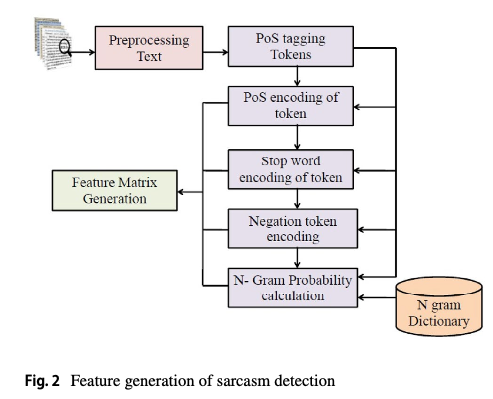

In [5]:
import pickle
dict_path = "/content/drive/My Drive/Kaggle Club/SARCASM PROJECT '25/ngram_dict_apr6.pickle"
with open(dict_path, 'rb') as f:
    ngram_dict = pickle.load(f)

In [9]:
ngram_dict

{'bangladeshi': (0.5, 0.5),
 'thesis': (0.5333333333333333, 0.4666666666666667),
 'spend time': (0.5679012345679012, 0.43209876543209874),
 'so prod': (0.75, 0.24999999999999997),
 'with elementary': (0.0, 1.0),
 'for send': (0.5714285714285714, 0.42857142857142855),
 'economy i': (0.2, 0.8),
 'thank fam': (0.0, 1.0),
 'story short': (0.4444444444444444, 0.5555555555555556),
 'good judge': (1.0, 0.0),
 'team might': (0.5555555555555556, 0.4444444444444444),
 'find few': (0.3333333333333333, 0.6666666666666666),
 'tank mount': (1.0, 0.0),
 'our offense': (0.5517241379310345, 0.4482758620689655),
 'yaw': (0.42857142857142855, 0.5714285714285714),
 'their point': (0.5, 0.5),
 'healthcare free': (0.75, 0.24999999999999997),
 'till': (0.4380776340110906, 0.5619223659889094),
 'hit q.': (0.24999999999999997, 0.75),
 'not spend': (0.5693430656934306, 0.4306569343065693),
 'mechanism that': (0.5, 0.5),
 'to character': (0.46153846153846156, 0.5384615384615384),
 '1 er': (0.8235294117647058, 0.

In [10]:
def get_ngram_probs(ngram):
    # Look up probabilities; default to (0.5, 0.5) if not found.
    return ngram_dict.get(ngram, (0.5, 0.5))

def extract_ngram_probability_features(text):
    # Lowercase and process the text.
    text = text.lower()
    doc = nlp(text)

    # Extract tokens (ignoring whitespace).
    tokens = [token.text for token in doc if not token.is_space]
    total_tokens = len(tokens) if tokens else 1  # Avoid division by zero.

    # --- Unigram Features ---
    ps_total_unigram, pns_total_unigram = 0, 0
    for token in tokens:
        ps, pns = get_ngram_probs(token)
        ps_total_unigram += ps
        pns_total_unigram += pns
    avg_unigram_ps = ps_total_unigram / total_tokens
    avg_unigram_pns = pns_total_unigram / total_tokens

    # --- Bigram Features ---
    # Create bigrams from tokens.
    bigrams = list(zip(tokens, tokens[1:]))
    count_bigrams = len(bigrams) if bigrams else 1
    ps_total_bigram, pns_total_bigram = 0, 0
    for w1, w2 in bigrams:
        bigram = w1 + " " + w2
        ps, pns = get_ngram_probs(bigram)
        ps_total_bigram += ps
        pns_total_bigram += pns
    avg_bigram_ps = ps_total_bigram / count_bigrams
    avg_bigram_pns = pns_total_bigram / count_bigrams

    # Concatenate features into a single vector.
    features = [avg_unigram_ps, avg_unigram_pns, avg_bigram_ps, avg_bigram_pns]
    return features

In [ ]:
# Define stopword and negation lists
custom_stopwords = {"am", "the", "from", "on", "in", "at", "of", "a", "an"}  # You can customize this
negation_words = {"not", "no", "never", "n't", "nothing", "none"}

# POS tag mapping to a fixed 9-dimension vector
POS_TAGS = {
    "NOUN": 0, "PRON": 1, "VERB": 2, "ADV": 3, "ADJ": 4,
    "DET": 5, "CCONJ": 6, "AUX": 7, "PART": 8
}
POS_DIM = len(POS_TAGS)

def extract_handcrafted_features(text):
    doc = nlp(text.lower())
    tokens = [token for token in doc if not token.is_space]

    # Initialize feature vectors
    pos_vector = np.zeros(POS_DIM, dtype=np.float32)
    stopword_flags = []
    negation_flags = []

    for token in tokens:
        pos = token.pos_
        if pos in POS_TAGS:
            pos_vector[POS_TAGS[pos]] += 1

        stopword_flags.append(1 if token.text in custom_stopwords else 0)
        negation_flags.append(1 if token.text in negation_words else 0)

    # Normalize POS vector
    if len(tokens) > 0:
        pos_vector /= len(tokens)

    # Aggregate stopword and negation flags
    stopword_ratio = np.mean(stopword_flags) if stopword_flags else 0
    negation_ratio = np.mean(negation_flags) if negation_flags else 0

    ngram_feats = extract_ngram_probability_features(text)

    # Final feature vector: [n-gram feats (4)] + [POS one-hot (9)] + [stopword_ratio (1)] + [negation_ratio (1)]
    # Final feature vector: [POS one-hot (9)] + [stopword_ratio (1)] + [negation_ratio (1)] + [n-gram feats (4)]
    return np.concatenate([pos_vector, [stopword_ratio, negation_ratio], ngram_feats ])


In [ ]:
# Apply to all comments
train_df['features'] = train_df['comment'].apply(lambda c: extract_handcrafted_features(str(c)))
# valid_df['features'] = valid_df['comment'].apply(lambda c: extract_handcrafted_features(str(c)))
test_df['features'] = test_df['comment'].apply(lambda c: extract_handcrafted_features(str(c)))

train_df

,label,comment,features
928042,0,central illinois,"[0.4735671936758893, 0.5264328063241107, 0.333..."
563885,0,to think cnn use to be acronym synonymous with...,"[0.491456428675727, 0.508543571324273, 0.42331..."
754036,0,but then again you have to consider that all h...,"[0.48015374906428243, 0.5198462509357175, 0.44..."
361336,0,ughhhhh,"[0.33333333333333337, 0.6666666666666667, 0.0,..."
930956,1,to ensure you be never late to hairdresser,"[0.5208433991907238, 0.47915660080927625, 0.58..."
...,...,...,...
203592,1,because he chaingrab sheik ditto who want guy ...,"[0.5530832218009684, 0.4469167781990317, 0.539..."
912438,0,rubicon mango,"[0.3872549019607843, 0.6127450980392157, 0.5, ..."
239813,0,essentially gap insurance right,"[0.48563155779657186, 0.5143684422034281, 0.5,..."
654353,0,yeah but sometimes that weird kid keep try to ...,"[0.502379614845161, 0.4976203851548389, 0.4734..."


In [ ]:
# Save after feature extraction
train_df.to_pickle("/content/drive/My Drive/Kaggle Club/SARCASM PROJECT '25/train_sarcasm_dataset_with_features.pkl")
# valid_df.to_pickle("/content/drive/My Drive/Kaggle Club/SARCASM PROJECT '25/val_sarcasm_dataset_with_features.pkl")
test_df.to_pickle("/content/drive/My Drive/Kaggle Club/SARCASM PROJECT '25/test_sarcasm_dataset_with_features.pkl")

Load saved features

# Training

In [12]:
train_feature_df = pd.read_pickle("/content/drive/My Drive/Kaggle Club/SARCASM PROJECT '25/train_sarcasm_dataset_with_features.pkl")
# valid_df.to_pickle("/content/drive/My Drive/Kaggle Club/SARCASM PROJECT '25/val_sarcasm_dataset_with_features.pkl")
test_feature_df = pd.read_pickle("/content/drive/My Drive/Kaggle Club/SARCASM PROJECT '25/test_sarcasm_dataset_with_features.pkl")

In [46]:
nan_rows = train_feature_df[train_feature_df['comment'].isna()]
print(nan_rows)

        label comment                                           features
30252       0     NaN  [0.1887905604719764, 0.8112094395280236, 0.0, ...
602         0     NaN  [0.1887905604719764, 0.8112094395280236, 0.0, ...
524263      1     NaN  [0.1887905604719764, 0.8112094395280236, 0.0, ...
162762      0     NaN  [0.1887905604719764, 0.8112094395280236, 0.0, ...
179912      0     NaN  [0.1887905604719764, 0.8112094395280236, 0.0, ...
...       ...     ...                                                ...
872624      0     NaN  [0.1887905604719764, 0.8112094395280236, 0.0, ...
503308      1     NaN  [0.1887905604719764, 0.8112094395280236, 0.0, ...
218473      0     NaN  [0.1887905604719764, 0.8112094395280236, 0.0, ...
56269       1     NaN  [0.1887905604719764, 0.8112094395280236, 0.0, ...
167930      0     NaN  [0.1887905604719764, 0.8112094395280236, 0.0, ...

[1000 rows x 3 columns]


In [13]:
print(train_feature_df.shape)
train_feature_df = train_feature_df.dropna()
print(train_feature_df.shape)

(808660, 3)
(807660, 3)


In [14]:
print(test_feature_df.shape)
test_feature_df = test_feature_df.dropna()
print(test_feature_df.shape)

(202166, 3)
(201903, 3)


In [15]:
# Assuming df['features'] is a column of 15-element arrays/lists
def rearrange_features(row):
    features = row['features']
    comment = row['comment']

    # Extract the original components
    orig_ngram_feats = features[:4]
    pos_one_hot = features[4:13]
    stopword_ratio = features[13]
    negation_ratio = features[14]

    # Recalculate n-gram features
    new_ngram_feats = extract_ngram_probability_features(comment)

    # Reassemble in the desired order
    new_features = np.concatenate([
        pos_one_hot,
        [stopword_ratio],
        [negation_ratio],
        new_ngram_feats
    ])
    return new_features

train_feature_df['features'] = train_feature_df.apply(rearrange_features, axis=1)
test_feature_df['features'] = test_feature_df.apply(rearrange_features, axis=1)

In [52]:
# Final feature vector: [POS one-hot (9)] + [stopword_ratio (1)] + [negation_ratio (1)] + [n-gram feats (4)]
# POS_TAGS = {
#     "NOUN": 0, "PRON": 1, "VERB": 2, "ADV": 3, "ADJ": 4,
#     "DET": 5, "CCONJ": 6, "AUX": 7, "PART": 8
# }
train_feature_df

,label,comment,features
928042,0,central illinois,"[0.5, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, ..."
563885,0,to think cnn use to be acronym synonymous with...,"[0.20000000298023224, 0.0, 0.20000000298023224..."
754036,0,but then again you have to consider that all h...,"[0.1599999964237213, 0.03999999910593033, 0.20..."
361336,0,ughhhhh,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
930956,1,to ensure you be never late to hairdresser,"[0.125, 0.125, 0.125, 0.125, 0.125, 0.0, 0.0, ..."
...,...,...,...
203592,1,because he chaingrab sheik ditto who want guy ...,"[0.25, 0.3333333432674408, 0.1666666716337204,..."
912438,0,rubicon mango,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
239813,0,essentially gap insurance right,"[0.5, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
654353,0,yeah but sometimes that weird kid keep try to ...,"[0.125, 0.2083333283662796, 0.25, 0.0416666679..."


In [53]:
test_feature_df

,label,comment,features
905026,0,hey it be just matter time before someone broo...,"[0.1666666716337204, 0.25, 0.0833333358168602,..."
928517,0,but lulu be already 1350 skin skins sale be 97...,"[0.2142857164144516, 0.0, 0.1428571492433548, ..."
294255,0,it be tricky than i think,"[0.0, 0.3333333432674408, 0.1666666716337204, ..."
233744,1,they keep shoot themselves because we need mor...,"[0.3076923191547394, 0.23076923191547394, 0.23..."
281434,0,maybe that be why his colon try to kill he rev...,"[0.09090909361839294, 0.27272728085517883, 0.3..."
...,...,...,...
30217,0,catcher have mini panic attack thinking fuck d...,"[0.29411765933036804, 0.11764705926179886, 0.2..."
578010,0,i be so sad when he and katy perry break up,"[0.0, 0.1818181872367859, 0.1818181872367859, ..."
712223,1,thank national medium for hype this up so much...,"[0.18518517911434174, 0.14814814925193787, 0.1..."
283255,0,it be not like i have not have diarrhea for ho...,"[0.1666666716337204, 0.1666666716337204, 0.166..."


In [16]:
# Save after feature extraction
train_feature_df.to_pickle("/content/drive/My Drive/Kaggle Club/SARCASM PROJECT '25/train_sarcasm_dataset_with_features_fixedapr6.pkl")
# valid_df.to_pickle("/content/drive/My Drive/Kaggle Club/SARCASM PROJECT '25/val_sarcasm_dataset_with_features.pkl")
test_feature_df.to_pickle("/content/drive/My Drive/Kaggle Club/SARCASM PROJECT '25/test_sarcasm_dataset_with_features_fixedapr6.pkl")

In [17]:
# Step 4: Convert to arrays
X_train = np.vstack(train_feature_df['features'].to_numpy())
y_train = train_feature_df['label'].values

# X_val = np.vstack(valid_df['features'].to_numpy())
# y_val = valid_df['label'].values

X_test = np.vstack(test_feature_df['features'].to_numpy())
y_test = test_feature_df['label'].values

print("Final feature shape per sample:", X_train.shape[1])
print("Train set shape:", X_train.shape)
# print("Val set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Final feature shape per sample: 15
Train set shape: (807660, 15)
Test set shape: (201903, 15)


In [ ]:
# # -----------------------------------------------
# # CONVERT TO TENSORFLOW DATASET
# # -----------------------------------------------

# def array_to_tf_dataset(features, labels):
#     ds = tf.data.Dataset.from_tensor_slices((features, labels))
#     return ds

# batch_size = 32

# train_ds = array_to_tf_dataset(X_train, y_train).batch(batch_size)
# # val_ds = array_to_tf_dataset(X_val, y_val).batch(batch_size)
# test_ds = array_to_tf_dataset(X_test, y_test).batch(batch_size)


In [18]:
# -----------------------------------------------
# BUILD AND TRAIN TF-DF RANDOM FOREST
# -----------------------------------------------
# rf_model = tfdf.keras.RandomForestModel(
#     task=tfdf.keras.Task.CLASSIFICATION,
#     num_trees=200,
#     max_depth=10,
#     random_seed=42,
#     verbose=1
# )
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,         # More trees = better stability
    max_depth=10,             # Prevent overfitting on short feature vectors
    min_samples_split=5,      # Be a bit stricter about splitting
    min_samples_leaf=3,       # Helps with generalization
    class_weight='balanced',  # Useful if your sarcasm classes are imbalanced
    random_state=42,          # Reproducibility
    n_jobs=-1,                 # Use all CPU cores
    verbose=1
)

# rf_model = RandomForestClassifier(
#     n_estimators=100,
#     criterion='gini',
#     max_depth=None,
#     min_samples_split=2,
#     min_samples_leaf=1,
#     bootstrap=True,
#     random_state=42,
#     n_jobs=-1,
#     verbose=1
# )


In [19]:
# # Convert tf.Dataset back to NumPy for sklearn
# X_train_np = np.vstack([x.numpy() for x, _ in train_ds])
# y_train_np = np.concatenate([y.numpy() for _, y in train_ds])
rf_model.fit(X_train, y_train)



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  6.4min finished


RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=3, min_samples_split=5,
                       n_estimators=200, n_jobs=-1, random_state=42, verbose=1)

In [20]:
# X_test_np = np.vstack([x.numpy() for x, _ in test_ds])
# y_test_np = np.concatenate([y.numpy() for _, y in test_ds])

# print("\Test Accuracy:", rf_model.score(X_test_np, y_test_np))
print("Accuracy:", rf_model.score(X_test, y_test))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.7s


Accuracy: 0.7023570724555851


[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    2.8s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    2.9s finished


In [10]:
# # USE FOR TENSORFLOW MODELS ONLY

# eval_result = rf_model.evaluate(val_ds, return_dict=True)
# print("\nValidation Accuracy:", eval_result["accuracy"])

# test_result = rf_model.evaluate(test_ds, return_dict=True)
# print("Test Accuracy:", test_result["accuracy"])

# rf_model.summary()

In [ ]:
# # -----------------------------------------------
# # 8) MODEL EVALUATION
# # -----------------------------------------------

# y_pred_probs = rf_model.predict(test_ds)
# # For a binary classification, shape is (N, 2) => we argmax over axis=1
# y_pred = np.argmax(y_pred_probs, axis=1)

# acc = accuracy_score(y_test, y_pred)
# print("Test Accuracy:", acc)


In [21]:
from sklearn.metrics import classification_report

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred, digits=4))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.7s


              precision    recall  f1-score   support

           0     0.6933    0.7249    0.7087    100860
           1     0.7123    0.6798    0.6957    101043

    accuracy                         0.7024    201903
   macro avg     0.7028    0.7024    0.7022    201903
weighted avg     0.7028    0.7024    0.7022    201903



[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    2.8s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    2.8s finished


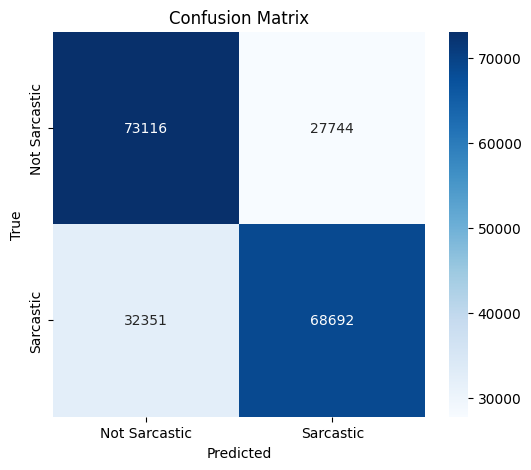

In [22]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Step 2: Get true labels from the test dataset
# If test_ds was built from numpy arrays
# y_true = np.concatenate([y for x, y in test_ds], axis=0)
if len(y_test.shape) == 2:
    y_true = np.argmax(y_test, axis=1)  # Convert one-hot to class indices
else:
    y_true = y_test

cm = confusion_matrix(y_true, y_pred)

# Step 4: Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Sarcastic', 'Sarcastic'], yticklabels=['Not Sarcastic', 'Sarcastic'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
